In [2]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

# 2dp3 Sensor Gen Distribution - CUDA accelerated

In [1]:
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = display("text/markdown", md)

In [2]:
push!(LOAD_PATH, "../src");
include("../src/pose.jl")
include("src/csail_data.jl")
include("../src/cuda_raycaster_point_cloud_b.jl");

"""
    zs_ = cast_cu(ps_::CuArray, ys_::CuArray; fov=2π, zmax=Inf, cell_rad=0.01)

Computes depth measurements `zs_` with respect to a matrix of poses `ps_`
and a point cloud matrix `ys_` ...
"""
function cast_cu(ps_::CuArray, ys_::CuArray; fov=2π, zmax=Inf, cell_rad=0.05)
    zs_ = zmax*CUDA.ones(size(ps_, 1), 361)
    cast_cu!(zs_, ys_, ps_; fov=fov, cell_rad=cell_rad)
    return zs_
end;

Loading `../data/mit-csail.json` ...

	_zs 	Vector{Vector{Float64}}
	_zs_inf 	Vector{Vector{Float64}}
	_as 	Vector{Float64}
	_zmax 	Float64
	_ys 	Vector{Vector{Vector{Float64}}}
	_ys_inf 	Vector{Vector{Vector{Float64}}}
	_num_a 	Int64
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Control}
	_T 	Int64


We only use the above includes for visualization purposes. The actual module starts here. 

In [219]:
#nbx --fname=src/sensor_distribution.jl
push!(LOAD_PATH, "../src");
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using BenchmarkTools
using CUDA
using Gen
using MyUtils # ../src
using GenDistributionZoo: diagnormal 
using Test

In [4]:
#nbx
"""
    log_p = gaussian_logpdf(x, mu, sig)

Benchmarked in `33 - CUDA Accelerated Gen Distributions`.
"""
function gaussian_logpdf(x, mu, sig)
    d = (x .- mu).^2 ./ sig.^2
    log_p = - log.(sig) .- log(sqrt(2π)) .- 1/2 * d
    return log_p
end;

Just a quick reality check that we did not mess anything up in the definition above.

In [44]:
@testset "Gaussian reality check" begin 
for i=1:100
    x   = rand()
    mu  = rand()
    sig = rand()
    
    @test isapprox(logpdf(normal,  x, mu, sig), 
                   gaussian_logpdf(x, mu, sig))
    @test gaussian_logpdf(x, Inf, 1.0)   == -Inf
    @test gaussian_logpdf(Inf, 0.0, 1.0) == -Inf
end 
end;

Test Summary:          | Pass  Total  Time
Gaussian reality check |  300    300  0.0s


In [232]:
#nbx
"""
```julia
    logsumexp(x; dims)
```
Applies `logsumexp` along specified dimensions.
"""
function Gen.logsumexp(x; dims)
    c = maximum(x, dims=dims)
    y = c .+ log.(sum(exp.(x .- c), dims=dims))
    y[isnan.(y)] .= - Inf
    return y
end;

In [237]:
x = rand(2000,2000)
x[1,:] .= -Inf

x_ = CuArray(x) 
y_ = logsumexp(x_; dims=2)


2000×1 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
 -Inf
   8.14044931957247
   8.150299086611525
   8.145997704534377
   8.135344210707451
   8.135114338971922
   8.146728772192624
   8.136645543060771
   8.148852297266854
   8.137012633937305
   8.137502267999155
   8.135370439146987
   8.150927544771939
   ⋮
   8.142269625676649
   8.13384155467324
   8.145630624504475
   8.150427686591831
   8.14609152059896
   8.1555113360702
   8.148886136002533
   8.154038063596085
   8.129919216969835
   8.148078787139026
   8.14840194588999
   8.159021861630016

In [125]:
@doc logsumexp

```julia
    logsumexp(x; dims)
```

Applies `logsumexp` along specified dimensions.


```julia
    logsumexp(x; dims)
```

Applies `logsumexp` along specified dimensions.


## Sliding windows

In [238]:
#nbx 
"""
    griddims = cuda_grid(datadims::Tuple{Vararg{Int}},
                         blockdims::Tuple{Vararg{Int}})

Given data dimensions `datadims` and number of threads
in each dimension `blockdims` returns the respective
grid dimensions `griddims` such that

    griddims[i] = ceil(Int, datadims[i]/blockdims[i])

"""
function cuda_grid(datadims::Tuple{Vararg{Int}}, blockdims::Tuple{Vararg{Int}})
    griddims = ceil.(Int, datadims./blockdims)
    return griddims
end

# Todo: handle wrap around and padding smarter?
"""
    slw_kernel!(x, y, w, pad, fill_val)

CUDA kernel to compute sliding windows.
Takes CuArrays of shape `(k,n)` and `(k,n,2w+1)`...
"""
function slw_kernel!(x, y, w::Int, wrap::Bool, fill::Bool, fill_val::Float64)
    
    m = 2*w + 1
    n = size(x,2)

    # Make sure the arrays are 
    # of the right shape
    @assert ndims(x)  == 2
    @assert ndims(y)  == ndims(x) + 1
    @assert size(x,1) == size(y,1)
    @assert size(x,2) == size(y,2)
    @assert size(y,3) == m
    
    # Thread id's
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    iz = (blockIdx().z - 1) * blockDim().z + threadIdx().z
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
    sz = gridDim().z * blockDim().z
        
    for j_pose = ix:sx:size(y,1), j_obs = iy:sy:size(y,2), j_mix = iz:sz:size(y,3)
        # Transform mixture index in `1:m` 
        # to offsets in `-w:w`
        offset = j_mix-1-w
        
        j = j_obs + offset
        if wrap
            j = mod(j - 1 , n) + 1
            val = x[j_pose, j]
        else
            if 1 <= j <= n
                val = x[j_pose, j]
            else
                if fill
                    val = fill_val
                else
                    j = max(min(j,n),1)
                    val = x[j_pose, j]
                end
            end
        end
        
        # Fill entries of `y`
        @inbounds y[j_pose, j_obs, j_mix] = val
    end
    return
end

"""
```julia
    y = slw_cu!(x::CuArray, w::Int; blockdims=(8,8,4), wrap=false, pad_val=nothing)
```
CUDA-accelerated function computing sliding windows. 
Takes a CuArray of shape `(k,n)` and returns a CuArray
of shape `(k,n,m)`, where `m = 2w+1`....
"""
function slw_cu!(x::CuArray, w::Int; blockdims=(8,8,4), wrap=false, fill=false, fill_val=Inf)
    
    k = size(x, 1)
    n = size(x, 2)
    m = 2*w+1
    
    y = CUDA.ones(k,n,m)
    
    # `cuda_grid` defined in reaycaster file, I also put it in utils
    griddims = cuda_grid((k,n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims slw_kernel!(x, y, w, wrap, fill, fill_val)
    end
    
    return y
end;

In [239]:
k = 10
n = 7
w = 2

x  = stack(fill(collect(1.0:n), k))
x_ = CuArray(x)

y_ = slw_cu!(x_, w, blockdims=(8,8,4), wrap=false, fill=true, fill_val=Inf)
y  = Array(y_);
y[1,:,:]

7×5 Matrix{Float32}:
 Inf   Inf   1.0   2.0   3.0
 Inf    1.0  2.0   3.0   4.0
  1.0   2.0  3.0   4.0   5.0
  2.0   3.0  4.0   5.0   6.0
  3.0   4.0  5.0   6.0   7.0
  4.0   5.0  6.0   7.0  Inf
  5.0   6.0  7.0  Inf   Inf

## 2D Sensor Distribution (for point clouds)

### Mixture components

In [15]:
#nbx
MyUtils.polar_inv(z::CuArray, a::CuArray) = cat(z.*cos.(a), z.*sin.(a), dims=ndims(a)+1);

In [16]:
#nbx
"""
    ys_tilde_ = get_ys_tilde_cu(zs_::CuArray, w::Int)    

Computes the 2d mixture components for the "2dp3" likelihood from 
    depth measurements `zs_` along angles `as_`, and with a filter radius of `w`.
    
    Arguments:
            zs_: Range measurements `(k,n)`
            as_: Angles of measuremnts `(n,)`
            w:   Filter window radius
    
    Returns:
        CuArray of shape `(k, n, 2w+1, 2)`
"""
function get_ys_tilde_cu(zs_::CuArray, as_::CuArray, w::Int; wrap=false, fill=false, fill_val=0.0)   

    zs_tilde_ = slw_cu!(zs_, w; blockdims=(8,8,4), wrap=wrap)
    as_tilde_ = slw_cu!(reshape(as_,1,:), w; blockdims=(8,8,4), wrap=wrap)
    ys_tilde_ = polar_inv(zs_tilde_, as_tilde_)
    
    return ys_tilde_
end;

In [335]:
#nbx
# Same as above but want to switch 
# to different name going forward
"""
```julia
    ỹ_::CuArray = get_2d_mixture_components(z_::CuArray, a_::CuArray, w::Int; 
                                            wrap=false, fill=true, 
                                            fill_val_z=Inf, fill_val_a=Inf)
```
Computes the 2d mixture components for the "2dp3" likelihood from a family 
depth scans `z_` along angles `a_`, and with a filter radius of `w`.

Arguments:
 - `z_`:    Range measurements `(k,n)`
 - `a_`:    Angles of measuremnts `(n,)`
 - `w`:     Filter window size

Returns:
 - `ỹ_`: CuArray of shape `(k, n, m, 2)`, where `m=2w+1`
"""
function get_2d_mixture_components(z_::CuArray, a_::CuArray, w::Int; 
                                   wrap=false, fill=true, fill_val_z=Inf, fill_val_a=Inf)
    
    z̃_ = slw_cu!(             z_, w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val_z)
    ã_ = slw_cu!(reshape(a_,1,:), w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val_a)
    ỹ_ = polar_inv(z̃_, ã_)
    
    # Handle Inf's and NaN
    ỹ_[isnan.(ỹ_)] .= Inf

    return ỹ_
end

get_2d_mixture_components

In [336]:
@doc get_2d_mixture_components

```julia
    ỹ_::CuArray = get_2d_mixture_components(z_::CuArray, a_::CuArray, w::Int; 
                                            wrap=false, fill=true, 
                                            fill_val_z=Inf, fill_val_a=Inf)
```

Computes the 2d mixture components for the "2dp3" likelihood from a family  depth scans `z_` along angles `a_`, and with a filter radius of `w`.

Arguments:

  * `z_`:    Range measurements `(k,n)`
  * `a_`:    Angles of measuremnts `(n,)`
  * `w`:     Filter window size

Returns:

  * `ỹ_`: CuArray of shape `(k, n, m, 2)`, where `m=2w+1`


```julia
    ỹ_::CuArray = get_2d_mixture_components(z_::CuArray, a_::CuArray, w::Int; 
                                            wrap=false, fill=true, 
                                            fill_val_z=Inf, fill_val_a=Inf)
```

Computes the 2d mixture components for the "2dp3" likelihood from a family  depth scans `z_` along angles `a_`, and with a filter radius of `w`.

Arguments:

  * `z_`:    Range measurements `(k,n)`
  * `a_`:    Angles of measuremnts `(n,)`
  * `w`:     Filter window size

Returns:

  * `ỹ_`: CuArray of shape `(k, n, m, 2)`, where `m=2w+1`


### Likelihood

In [337]:
#nbx
"""
```julia
    log_ps, ptw = sensor_logpdf(x, ỹ, sig, outlier, outlier_vol=1.0; return_pointwise=false)
```
Evaluates an observation `x` under the 2dp3 likelihood with <br/>
a family of mixture components `ỹ` and parameters `sig`, `outlier`, and `outlier_vol`.

Arguments:
 - `x`:  Observation point cloud `(n,2)`
 - `ỹ`: Family of mixture components `(k,n,m,2)`
 - ...

Returns:
 - `log_ps`: Log-probs `(k,)`
 - `ptw`:    Pointwise log-probs for each observation point `(k,n)`
"""
function sensor_logpdf(x, ỹ, sig, outlier, outlier_vol=1.0; return_pointwise=false) 
    @assert size(x,1) == size(ỹ,2)

    k = size(ỹ,1)
    n = size(ỹ,2)
    m = size(ỹ,3)
    x = reshape(x, 1, n, 1, 2)
    
    # Line by line: ...
    #   Compute 1D Gaussians (k,n,m,2)
    #   Convert to 2D gausians (k,n,m,1)
    #   Convert to mixture `gm` of m 2D gausians (k,n,1,1)
    #   Convert to mixture of `gm` and `outlier` (k,n,1,1)
    log_p = gaussian_logpdf(x, ỹ, sig)
    log_p = sum(log_p, dims=4)
    log_p = logsumexp(log_p .- log(m), dims=3)
    log_p = log.((1 .- outlier).*exp.(log_p) .+ outlier./outlier_vol)
    
    # If we don't need pointwise logprobs
    # we can save us the time and space to copy
    pointwise = nothing
    if return_pointwise
        pointwise = dropdims(log_p, dims=(3,4))
    end

    # Convert to product of mixtures (k,1,1,1)
    log_p = sum(log_p, dims=2)
    log_p = dropdims(log_p, dims=(2,3,4))

    return log_p, pointwise
end
# Todo: Make sure we handle Inf's in y correctly (that might come from sliding window fills)? 


sensor_logpdf

In [338]:
@doc sensor_logpdf

```julia
    log_ps, ptw = sensor_logpdf(x, ỹ, sig, outlier, outlier_vol=1.0; return_pointwise=false)
```

Evaluates an observation `x` under the 2dp3 likelihood with <br/> a family of mixture components `ỹ` and parameters `sig`, `outlier`, and `outlier_vol`.

Arguments:

  * `x`:  Observation point cloud `(n,2)`
  * `ỹ`: Family of mixture components `(k,n,m,2)`
  * ...

Returns:

  * `log_ps`: Log-probs `(k,)`
  * `ptw`:    Pointwise log-probs for each observation point `(k,n)`


```julia
    log_ps, ptw = sensor_logpdf(x, ỹ, sig, outlier, outlier_vol=1.0; return_pointwise=false)
```

Evaluates an observation `x` under the 2dp3 likelihood with <br/> a family of mixture components `ỹ` and parameters `sig`, `outlier`, and `outlier_vol`.

Arguments:

  * `x`:  Observation point cloud `(n,2)`
  * `ỹ`: Family of mixture components `(k,n,m,2)`
  * ...

Returns:

  * `log_ps`: Log-probs `(k,)`
  * `ptw`:    Pointwise log-probs for each observation point `(k,n)`


In [339]:
k = 2
n = 3
m = 3

x   = rand(n,2)
ys  = rand(k,n,m,2)

# Insert some Inf's, that might come 
# from sliding window fills. 
ys[1,:,:,:] .= Inf

x_  = CuArray(x)
ys_ = CuArray(ys)

sig         = 1.0
outlier     = 0.1
outlier_vol = 10.0

log_ps , ptw  = sensor_logpdf(x , ys , sig, outlier, outlier_vol; return_pointwise=true)
log_ps_, ptw_ = sensor_logpdf(x_, ys_, sig, outlier, outlier_vol; return_pointwise=true)

@assert isapprox(log_ps, Array(log_ps_))
@assert isapprox(minimum(ptw[1,:]), log(outlier/outlier_vol))


In [145]:
#nbx
# Same as `sensor_logpdf` above
# (backwards compatibility)
"""
```julia
    sensor_smc_logpdf_cu(x, y, sig, outlier, outlier_vol; return_pointwise=false)
```
Evaluates an observation `x` under the 2dp3 likelihood with <br/>
a family of mixture components `ys` and parameters `sig`, `outlier`, and `outlier_vol`.

Arguments:
 - `x`:  Observation point cloud `(n,2)`
 - `ys`: Family of mixture components `(k,n,m,2)`
 - ...

Returns:
 - `log_ps`: Logprobs `(k,)`
 - `ptw`:    Logprobs of each observation point `(k,n)`
"""
function sensor_smc_logpdf_cu(x, y, sig, outlier, outlier_vol; return_pointwise=false)
    return sensor_logpdf(x, y, sig, outlier, outlier_vol; return_pointwise=return_pointwise)
end

sensor_smc_logpdf_cu

### Distribution

In [260]:
#nbx
struct SensorDistribution_CUDA <: Distribution{Vector{Vector{Float64}}} 
end

"""
    x::Vector{Vector{Float64}} = sensordist_cu(ỹ_::CuArray, sig, outlier, outlier_vol=1.0)

Distribution from the 2dp3-likelihood. Takes 2d-mixture components `ỹ_` and 
samples a vector `x` of 2d points.

Arguments:
 - `ỹ_`: 2d-mixture components `(n,m,2)`
 - ...
Returns:
- `x`: Observation vector of 2d points.
"""
const sensordist_cu = SensorDistribution_CUDA()

# Todo:
function Gen.logpdf(::SensorDistribution_CUDA, x, ỹ_::CuArray, sig, outlier, outlier_vol=1.0)
    n = size(ỹ_, 1)
    m = size(ỹ_, 2)
    
    x_ = CuArray(stack(x))
    ỹ_ = reshape(ỹ_, 1, n, m, 2) 
    
    log_p, = sensor_logpdf(x_, ỹ_, sig, outlier, outlier_vol) # CuArray of length 1
    return CUDA.@allowscalar log_p[1]
end

function Gen.random(::SensorDistribution_CUDA, ỹ_::CuArray, sig, outlier, outlier_vol=1.0)
    n = size(ỹ_,1)
    m = size(ỹ_,2)
    
    # Sample an observation point cloud `x`
    x = Vector{Float64}[]
    for i=1:n
        if bernoulli(outlier)
            # Todo: Change that to a uniform distribution, e.g. over a  
            #       circular area with radius `zmax`.
            x_i = [Inf;Inf]
        else
            j   = rand(1:m)
            y   = Array(ỹ_[i,j,:])
            x_i = diagnormal(y, [sig;sig])

        end
        push!(x, x_i)
    end
    
    return x
end

(D::SensorDistribution_CUDA)(args...)             = Gen.random(D, args...)
Gen.has_output_grad(::SensorDistribution_CUDA)    = false
Gen.has_argument_grads(::SensorDistribution_CUDA) = (false, false);

In [261]:
@doc sensordist_cu

```
x::Vector{Vector{Float64}} = sensordist_cu(ỹ_::CuArray, sig, outlier, outlier_vol=1.0)
```

Distribution from the 2dp3-likelihood. Takes 2d-mixture components `ỹ_` and  samples a vector `x` of 2d points.

Arguments:

  * `ỹ_`: 2d-mixture components `(n,m,2)`
  * ...

Returns:

  * `x`: Observation vector of 2d points.


```
x::Vector{Vector{Float64}} = sensordist_cu(ỹ_::CuArray, sig, outlier, outlier_vol=1.0)
```

Distribution from the 2dp3-likelihood. Takes 2d-mixture components `ỹ_` and  samples a vector `x` of 2d points.

Arguments:

  * `ỹ_`: 2d-mixture components `(n,m,2)`
  * ...

Returns:

  * `x`: Observation vector of 2d points.


In [154]:
n = 10
m = 3

ys  = rand(n,m,2)
ys_ = CuArray(ys)

sig         = 1.0
outlier     = 0.1
outlier_vol = 10.0
args = (ys_, sig, outlier, outlier_vol)
x = sensordist_cu(args...)
logpdf(sensordist_cu, x, args...)

-28.71455927888139

0


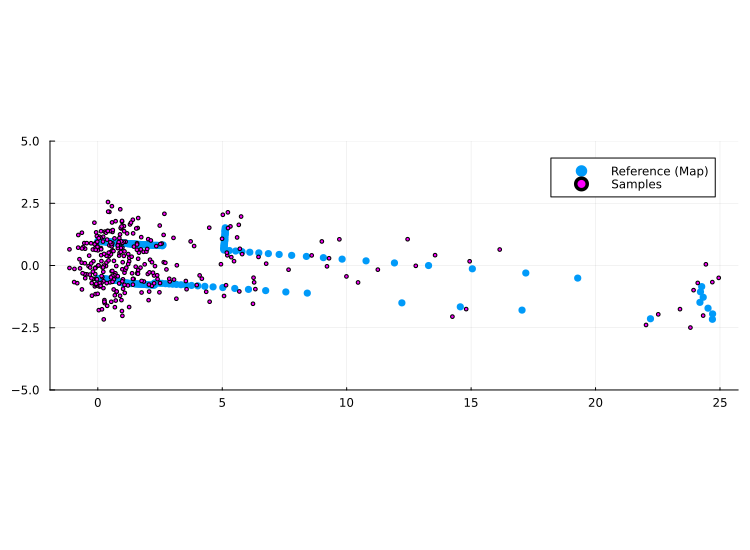

In [368]:
t = 1_050
zs_ = CuArray(stack([_zs[t]]))
as_ = CuArray(_as);

w           = 20
sig         = 0.6
outlier     = 0.1
outlier_vol = 100.


ỹ_ = get_2d_mixture_components(zs_, as_, w; wrap=false, fill=true, 
                                            fill_val_z=Inf, fill_val_a = Inf);

println(sum(isnan.(ỹ_)))


xs = [sensordist_cu(ỹ_[1,:,:,:], sig, outlier, outlier_vol) for i=1:1]
xs = reduce(vcat, xs)
# ----------------
mypl = plot(size=(750,550), aspect_ratio=:equal, ylim=(-5,5))
scatter!(_ys_inf[t], markerstrokewidth=0, c=col[1], label="Reference (Map)")

args = (
    markersize=2, 
    alpha=1., 
    markerstrokewidth=1,
    c=:magenta
)
scatter!(xs; args..., label="Samples")

display(mypl)

## 1D Sensor Distribution

### 1D Mixture

In [242]:
#nbx
"""
```julia
    ỹ_, w̃_ = get_1d_mixture_components(z_, a_, w, sig; 
                                       wrap=false, fill=true, 
                                       fill_val_z=Inf, fill_val_a=Inf)
```
Computes the 1d mixture components and their weights for the "2dp3" likelihood 
(or rather for the induced line distributions) from depth measurements `z_` 
along angles `a_`, and with a filter radius of `w`.

Arguments:
 - `z_`: Range measurements `(k,n)`
 - `a_`: Angles of measuremnts `(n,)`
 - `w``: Filter window radius

Returns:
 - `ỹ_`: 1d mixture components `(k, n, m)`, where `m2w+1`
 - `w̃_`: 1d mixture weights `(k, n, m)`, where `m2w+1`
"""
function get_1d_mixture_components(z_, a_, w, sig; 
                                   wrap=false, fill=true, 
                                   fill_val_z=Inf, fill_val_a=Inf)
    a_ = reshape(a_,1,:)
    z̃_ = slw_cu!(z_, w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val_z)
    ã_ = slw_cu!(a_, w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val_a)
    
    # We compute the projection `ỹ` of the 2d mixtures onto 
    # the ray through each pixel and their distance `d̃` to the rays.
    #
    # Note that the embedded point is of the form `[z*cos(a), z*cos(a)]` and 
    # the projections are given by the dot products with the x- and y-axis.
    ã_ = π/2 .- ã_ .+ a_
    d̃_ = z̃_ .* cos.(ã_)
    ỹ_ = z̃_ .* sin.(ã_)
    
    # Handle Inf's and NaN
    d̃_[isnan.(d̃_)] .= Inf
    ỹ_[isnan.(ỹ_)] .= Inf

    # Compute normalized mixture weights
    w̃_ = gaussian_logpdf(d̃_, 0.0, sig)
    w̃_ = w̃_ .- logsumexp(w̃_, dims=3)

    return ỹ_, w̃_
end;

In [243]:
zs_ = CuArray(stack([_zs[t]]))
as_ = CuArray(_as);

w           = 20
sig         = 0.1
outlier     = 0.1
outlier_vol = 100.

ys_tilde_, ws_tilde_ = get_1d_mixture_components(zs_, as_, w, sig,
                                 wrap=false, fill=true, fill_val_z=Inf, fill_val_a = Inf);

sum(isnan.(ys_tilde_)), 
sum(isnan.(ws_tilde_))

(0, 0)

### 1d Likelihood

In [244]:
#nbx
"""
    log_ps, ptw = sensor_logpdf_1d(z, ỹ, w̃, sig, outlier, outlier_vol; return_pointwise=false)

Evaluates an depth measurement `z` under the 2dp3 likelihood with <br/>
a family of 1d mixture components `ỹ` and their weights ` w̃` and <br/>
parameters `sig`, `outlier`, and `outlier_vol`.

Arguments:
    - `z`:  Depth measurements `(n,)`
    - `w̃`: Family of mixture components `(k,n,m)`
    - `ỹ`: Family of mixture components `(k,n,m)`
    - ...

Returns:
    - `log_ps`: Log-probs `(k,)`
    - `ptw`:    Pointwise log-probs for each observation point `(k,n)`
"""
function sensor_logpdf_1d(z, ỹ, w̃, sig, outlier, outlier_vol; return_pointwise=false)
    
    log_ps = gaussian_logpdf(z, ỹ, sig)
    log_ps = logsumexp(log_ps .+ w̃, dims=3)
    log_ps = log.((1 .- outlier).*exp.(log_ps) .+ outlier./outlier_vol)

    ptw = nothing
    if return_pointwise
        ptw = dropdims(log_ps, dims=3)
    end

    log_ps = sum(log_ps, dims=2)
    log_ps = dropdims(log_ps, dims=(2,3))

    return log_ps, ptw
end;
# Todo: We still have to truncate at zero. This is a distribution over the whole reals, including negative depths.

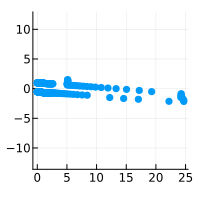

In [245]:
t = 1_050
# -----------------
mypl = plot(size=(200,200), aspect_ratio=:equal, legend=nothing)
scatter!(_ys_inf[t], markerstrokewidth=0)

(1, 361, 41)(1, 361, 41)
-6.907755278982137


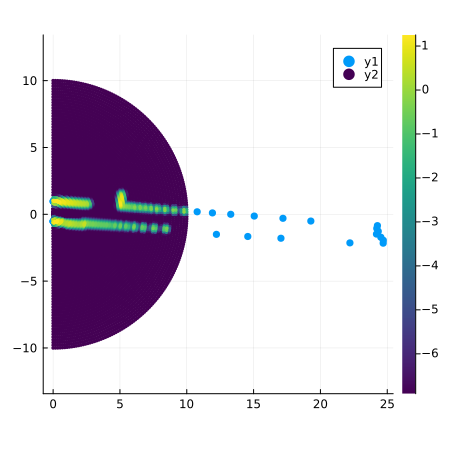

In [257]:
zs_ = CuArray(stack([_zs[t]]))
as_ = CuArray(_as);

w           = 20
sig         = 0.1
outlier     = 0.1
outlier_vol = 100.

ys_tilde_1d_, ws_tilde_1d_ = get_1d_mixture_components(zs_, as_, w, sig,
                                 wrap=false, fill=true, fill_val_z=Inf, fill_val_a = Inf);
log_p, ptw = sensor_logpdf_1d(zs_, ys_tilde_1d_, ws_tilde_1d_, sig, outlier, outlier_vol; return_pointwise=true);

println(size(ys_tilde_1d_), size(ws_tilde_1d_))

zs  = repeat(range(0.,10.,50), 1, 361)
zs_ = CuArray(zs)
log_p, ptw= sensor_logpdf_1d(zs_, ys_tilde_1d_, ws_tilde_1d_, sig, outlier, outlier_vol; return_pointwise=true);


# ----------------
mypl = plot(size=(450,450), aspect_ratio=:equal)
scatter!(_ys_inf[t], markerstrokewidth=0)
x = Vector{Float64}[]
v = Float64[]
for i=1:2:361
    x = vcat(x, [polar_inv(z,_as[i]) for z in zs[:,i]])
    v = vcat(v, ptw[:,i])
end
println(minimum(v))
perm = sortperm(v)
scatter!(x[perm], zcolor=v[perm], color=:viridis, markerstrokewidth=0, markersize=2)
mypl

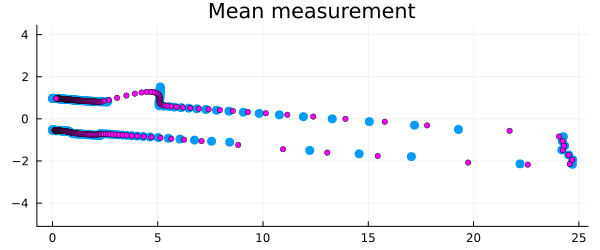

In [361]:
mu = logsumexp(ys_tilde_1d_ + ws_tilde_1d_, dims=3)[1,:,1]
mu = Array(mu)
# --------------------
mypl = plot(size=(600,250), aspect_ratio=:equal, legend=nothing, title="Mean measurement")
scatter!(_ys_inf[t], c=col[1], markerstrokewidth=0, markersize=5)
scatter!(polar_inv(mu, _as), c=:magenta, markerstrokewidth=1, markersize=3)

### Distribution

In [266]:
#nbx
struct SensorDistribution1d_CUDA <: Distribution{Vector{Float64}}
end

"""
    z::Vector{Float64} = sensordist1d_cu(ỹ, w̃, sig, outlier, outlier_vol=1.0)

Restricted distribution from the 2dp3-likelihood. 
Takes 1d-mixture components `ỹ` and their weights `w̃`,  and 
samples a vector `z` of depth values.

Arguments:
 - `ỹ`: 1d-mixture components `(n,m)`
 - `w̃`: 1d-mixture weights `(n,m)`
 - ...
Returns:
 - `z`: Observation vector of depth values `(n,)`
"""
const sensordist1d_cu = SensorDistribution1d_CUDA()

# Todo:
function Gen.logpdf(::SensorDistribution1d_CUDA, z, ỹ_, w̃_, sig, outlier, outlier_vol=1.0)
    n = size(ỹ, 1)
    m = size(ỹ, 2)
    
    z_ = CuArray(z)
    ỹ_ = reshape(ỹ_, 1, n, m) 
    w̃_ = reshape(w̃_, 1, n, m) 
    
    log_p, = sensor_logpdf_1d(z_, ỹ_, w̃_, sig, outlier, outlier_vol) # CuArray of length 1
    return CUDA.@allowscalar log_p[1]
end

function Gen.random(::SensorDistribution1d_CUDA, ỹ_, w̃_, sig, outlier, outlier_vol=1.0)
    n = size(ỹ_,1)
    m = size(ỹ_,2)
    
    # Sample an observation point cloud `x`
    z = Float64[]
    for i=1:n
        if bernoulli(outlier)
            # Todo: Change that to a uniform distribution using `zmax`.
            z_i = Inf
        else
            j   = categorical(exp.(w̃_[i,:]) )
            z_i = normal(ỹ_[i,j], sig)
        end
        push!(z, z_i)
    end
    
    return z
end

(D::SensorDistribution1d_CUDA)(args...)             = Gen.random(D, args...)
Gen.has_output_grad(::SensorDistribution1d_CUDA)    = false
Gen.has_argument_grads(::SensorDistribution1d_CUDA) = (false, false);

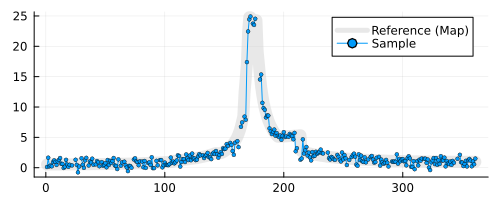

In [350]:
t = 1_050
zs_ = CuArray(stack([_zs[t]]))
as_ = CuArray(_as);

w           = 20
sig         = 0.5
outlier     = 0.1
outlier_vol = 100.

ỹ_, w̃_, = get_1d_mixture_components(zs_, as_, w, sig,
                                    wrap=false, fill=true, fill_val_z=Inf, fill_val_a = Inf);


z = sensordist1d_cu(ỹ[1,:,:], w̃[1,:,:], sig, outlier, outlier_vol)

# ----------------
mypl = plot(size=(500,200))
plot!(_zs[t], c=:lightgray, linewidth=12, alpha=0.5, label="Reference (Map)")
plot!(z, c=col[1],marker=:o, markersize=2, label="Sample")
display(mypl)

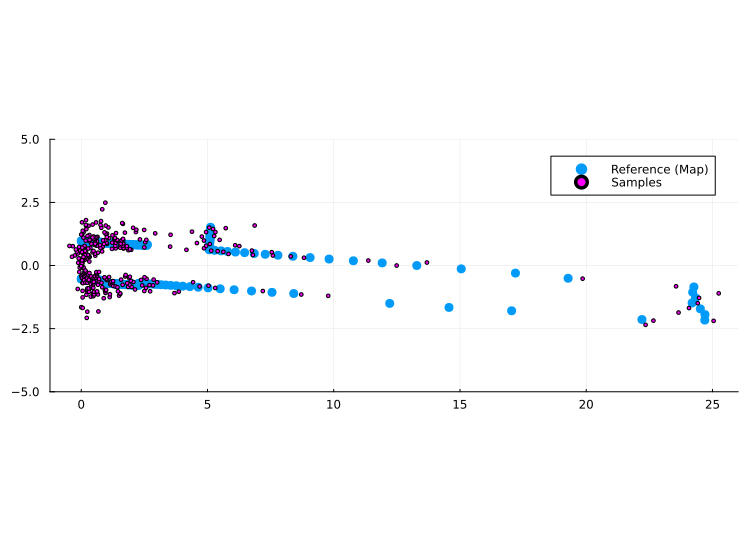

In [370]:
# ----------------
mypl = plot(size=(750,550), aspect_ratio=:equal, ylim=(-5,5))
scatter!(_ys_inf[t], markerstrokewidth=0, c=col[1], markersize=5, label="Reference (Map)")

args = (
    markersize=2, 
    alpha=1., 
    markerstrokewidth=1,
    c=:magenta
)
scatter!(polar_inv(z[1:1:end], _as[1:1:end]); args..., label="Samples")
for i=1:0
    z = sensordist1d_cu(ỹ[1,:,:], w̃[1,:,:], sig, outlier, outlier_vol)
    scatter!(polar_inv(z[1:1:end], _as[1:1:end]); args..., label=nothing)
end
display(mypl)